# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


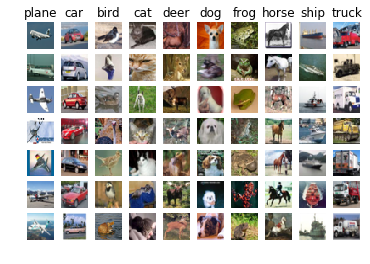

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


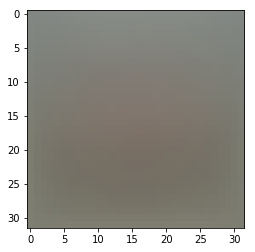

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [12]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.582667


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [18]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 0.043494 analytic: 0.043494, relative error: 6.368552e-09
numerical: -9.793982 analytic: -9.793982, relative error: 2.831321e-11
numerical: 0.458155 analytic: 0.458155, relative error: 7.029874e-11
numerical: 4.661394 analytic: 4.661394, relative error: 1.034009e-11
numerical: 7.111865 analytic: 7.111865, relative error: 2.182273e-12
numerical: 4.193105 analytic: 4.193105, relative error: 3.109585e-11
numerical: 7.516797 analytic: 7.516797, relative error: 4.570361e-11
numerical: -3.177719 analytic: -3.177719, relative error: 4.080518e-12
numerical: -11.144902 analytic: -11.144902, relative error: 3.721393e-11
numerical: 4.233802 analytic: 4.233802, relative error: 1.038529e-12
numerical: -4.010006 analytic: -4.010006, relative error: 5.946590e-11
numerical: -0.212222 analytic: -0.212222, relative error: 2.891293e-11
numerical: -21.186798 analytic: -21.186798, relative error: 3.605065e-12
numerical: -4.485460 analytic: -4.485460, relative error: 1.922348e-11
numerical: -30.4

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** 
**Could be different. This is caused by the non-linearity of the svm loss function. We know that a function of svm loss take the minimum of the 0 and the margin value. Basically it is the line that below x = 1(in this case) is a line with the nagetive gradient, but greater than x = 1 is 0, when we check a gradient around x = 1, the check may fail because that point is not differtiable**

In [19]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.5)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.5)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.582819e+00 computed in 0.199793s
Vectorized loss: 8.582819e+00 computed in 0.002218s
difference: -0.000000


In [20]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.187164s
Vectorized loss and gradient: computed in 0.003808s
difference: 0.000000


In [21]:
X_train

array([[ -71.64189796,  -73.98173469,  -69.47391837, ...,  -33.86195918,
         -42.39957143,    1.        ],
       [  23.35810204,   41.01826531,   54.52608163, ...,    7.13804082,
          29.60042857,    1.        ],
       [ 124.35810204,  119.01826531,  122.52608163, ...,  -39.86195918,
         -30.39957143,    1.        ],
       ...,
       [ -69.64189796,  -62.98173469,  -56.47391837, ...,   34.13804082,
           2.60042857,    1.        ],
       [-120.64189796, -131.98173469, -118.47391837, ...,   48.13804082,
          90.60042857,    1.        ],
       [  44.35810204,   57.01826531,   96.52608163, ...,  -47.86195918,
         -24.39957143,    1.        ]])

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [22]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 795.679455
iteration 100 / 1500: loss 289.642956
iteration 200 / 1500: loss 108.906332
iteration 300 / 1500: loss 43.428338
iteration 400 / 1500: loss 18.629184
iteration 500 / 1500: loss 9.974905
iteration 600 / 1500: loss 7.722556
iteration 700 / 1500: loss 5.468052
iteration 800 / 1500: loss 5.492649
iteration 900 / 1500: loss 5.215703
iteration 1000 / 1500: loss 5.324375
iteration 1100 / 1500: loss 5.338489
iteration 1200 / 1500: loss 5.600027
iteration 1300 / 1500: loss 5.098725
iteration 1400 / 1500: loss 5.820558
That took 3.278430s


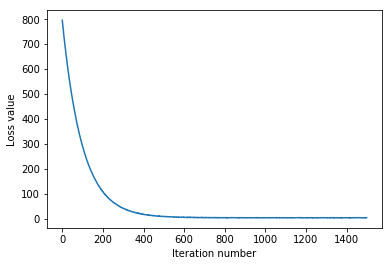

In [23]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [24]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.375102
validation accuracy: 0.374000


In [25]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-8, 1e-8]
regularization_strengths = [5e2, 1e3 ,3e3, 5e3, 1e4, 2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for rl in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=rl, reg=reg,
                      num_iters=4000, verbose=True)
        
        y_train_pred = svm.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        acc = np.mean(y_val == y_val_pred)
        if acc > best_val:
            best_val = acc
            best_svm = svm
        results[(rl, reg)] = (train_acc, acc)
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# lr 1.000000e-07 reg 3.000000e+03 train accuracy: 0.397551 val accuracy: 0.399000

iteration 0 / 4000: loss 34.442031
iteration 100 / 4000: loss 25.194463
iteration 200 / 4000: loss 24.344337
iteration 300 / 4000: loss 23.675526
iteration 400 / 4000: loss 21.341454
iteration 500 / 4000: loss 21.204051
iteration 600 / 4000: loss 20.981703
iteration 700 / 4000: loss 20.019511
iteration 800 / 4000: loss 21.013205
iteration 900 / 4000: loss 18.823319
iteration 1000 / 4000: loss 19.568294
iteration 1100 / 4000: loss 18.399181
iteration 1200 / 4000: loss 18.512626
iteration 1300 / 4000: loss 18.095900
iteration 1400 / 4000: loss 16.525928
iteration 1500 / 4000: loss 17.027229
iteration 1600 / 4000: loss 16.552496
iteration 1700 / 4000: loss 16.365485
iteration 1800 / 4000: loss 16.116230
iteration 1900 / 4000: loss 15.650028
iteration 2000 / 4000: loss 15.774069
iteration 2100 / 4000: loss 14.840759
iteration 2200 / 4000: loss 14.739092
iteration 2300 / 4000: loss 14.280404
iteration 2400 / 4000: loss 13.877182
iteration 2500 / 4000: loss 14.380959
iteration 2600 / 4000: l

iteration 2000 / 4000: loss 5.310933
iteration 2100 / 4000: loss 5.203429
iteration 2200 / 4000: loss 5.474137
iteration 2300 / 4000: loss 5.331198
iteration 2400 / 4000: loss 5.478866
iteration 2500 / 4000: loss 5.536631
iteration 2600 / 4000: loss 5.104479
iteration 2700 / 4000: loss 4.926466
iteration 2800 / 4000: loss 5.412868
iteration 2900 / 4000: loss 5.509789
iteration 3000 / 4000: loss 5.529968
iteration 3100 / 4000: loss 5.434795
iteration 3200 / 4000: loss 5.396610
iteration 3300 / 4000: loss 5.476648
iteration 3400 / 4000: loss 5.295924
iteration 3500 / 4000: loss 4.785605
iteration 3600 / 4000: loss 5.495021
iteration 3700 / 4000: loss 5.859523
iteration 3800 / 4000: loss 5.305451
iteration 3900 / 4000: loss 5.524773
iteration 0 / 4000: loss 1565.291350
iteration 100 / 4000: loss 210.885862
iteration 200 / 4000: loss 32.523787
iteration 300 / 4000: loss 9.774942
iteration 400 / 4000: loss 5.902560
iteration 500 / 4000: loss 5.687201
iteration 600 / 4000: loss 5.469786
iter

iteration 3900 / 4000: loss 7.962029
iteration 0 / 4000: loss 335.234003
iteration 100 / 4000: loss 261.279401
iteration 200 / 4000: loss 213.552889
iteration 300 / 4000: loss 174.637179
iteration 400 / 4000: loss 143.260938
iteration 500 / 4000: loss 117.991740
iteration 600 / 4000: loss 97.941052
iteration 700 / 4000: loss 79.772453
iteration 800 / 4000: loss 66.144565
iteration 900 / 4000: loss 54.433593
iteration 1000 / 4000: loss 45.904322
iteration 1100 / 4000: loss 38.432622
iteration 1200 / 4000: loss 32.433126
iteration 1300 / 4000: loss 26.569361
iteration 1400 / 4000: loss 23.338408
iteration 1500 / 4000: loss 19.235833
iteration 1600 / 4000: loss 16.564543
iteration 1700 / 4000: loss 15.009387
iteration 1800 / 4000: loss 13.198527
iteration 1900 / 4000: loss 11.246058
iteration 2000 / 4000: loss 10.763113
iteration 2100 / 4000: loss 9.227170
iteration 2200 / 4000: loss 8.073744
iteration 2300 / 4000: loss 7.677570
iteration 2400 / 4000: loss 7.023695
iteration 2500 / 4000: 

iteration 1900 / 4000: loss 83.931182
iteration 2000 / 4000: loss 82.233583
iteration 2100 / 4000: loss 81.447613
iteration 2200 / 4000: loss 79.443256
iteration 2300 / 4000: loss 79.436464
iteration 2400 / 4000: loss 77.683808
iteration 2500 / 4000: loss 76.519540
iteration 2600 / 4000: loss 76.129407
iteration 2700 / 4000: loss 74.196577
iteration 2800 / 4000: loss 74.550645
iteration 2900 / 4000: loss 73.396659
iteration 3000 / 4000: loss 71.357281
iteration 3100 / 4000: loss 71.482336
iteration 3200 / 4000: loss 70.622719
iteration 3300 / 4000: loss 69.866779
iteration 3400 / 4000: loss 68.552437
iteration 3500 / 4000: loss 68.130654
iteration 3600 / 4000: loss 68.243273
iteration 3700 / 4000: loss 67.306124
iteration 3800 / 4000: loss 65.853458
iteration 3900 / 4000: loss 64.934764
iteration 0 / 4000: loss 175.632246
iteration 100 / 4000: loss 167.519126
iteration 200 / 4000: loss 163.801808
iteration 300 / 4000: loss 159.586638
iteration 400 / 4000: loss 155.118026
iteration 500 

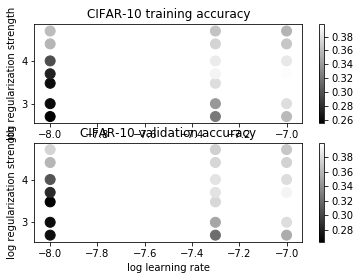

In [26]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [27]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.386000


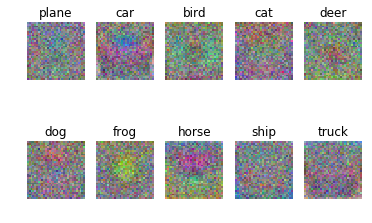

In [28]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *actually these paintings looks really abstract to me. If we look at it, somehow we can get some clues on how the class would be. because W should get dot producted to the sample, X. Then when this get maximize, this row of W should be in almost the same direction with X, to maximize their dot product. So idealy, we can figure out what the drawing is from differnet rows of W. We can basically figure out it is a horse and frog from the picture above* 